In [247]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbrn

fontsize = 13
custom = {"axes.edgecolor": "black","grid.linestyle": "dashed", "grid.color": "gray"}
sbrn.set_context('paper')
sbrn.set_style("whitegrid", rc = custom)

# Open the JSON file for reading
with open('slicejuly11.json', 'r') as file: #TODO add file
    data = json.load(file)

df = pd.json_normalize(data['benchmarks'])
df['repetition_index'] = df['repetition_index'].fillna(0)

In [248]:
# Customize the x-axis ticks to show byte values more clearly
from matplotlib.ticker import FuncFormatter

def byte_formatter(x, pos):
    if x == 0:
        return '0 B'
    elif x < 1024:
        return f'{int(x)} B'
    elif x < 1024**2:
        return f'{int(x / 1024)} KB'
    else:
        return f'{int(x / 1024**2)} MB'

# Customize the y-axis ticks to show time values more clearly
def time_formatter(y, pos):
    if y < 1:
        return f'{y * 1000:.1f} ns'
    elif y < 1000:
        return f'{y:.1f} us'
    elif y < 1000000:
        return f'{y / 1000:.1f} ms'
    else:
        return f'{y / 1000000:.1f} s'

In [249]:
extracted_data = []

# Loop through the benchmarks in the JSON data
for i,benchmark in df.iterrows() :
    
    # Extract the relevant information
    name = benchmark['name']
    real_time = benchmark['real_time']
    bytes = benchmark['bytes']
    
    # Determine the packing type from the name
    if 'deepcopy' in name:
        pack_type = 'DeepCopy'
    elif 'datatype' in name:
        pack_type = 'MPIDatatype'
    else:
        continue  # Skip if none
        
    # Determine the slice type from the name
    if 'noncontig2D' in name:
        slice_type = 'Noncontig2D'
    elif 'noncontig' in name:
        slice_type = 'Noncontig'
    elif 'contig' in name:
        slice_type = 'Contig'
    
    if 'mean' in name:
        extracted_data.append({'pack_type': pack_type, 'slice_type': slice_type, 'real_time': real_time, 'bytes': bytes})
    
edf = pd.DataFrame(extracted_data)

# Create a combined column for comm_type and func_type
edf['combined_type'] = edf['pack_type'] + ' ' + edf['slice_type']

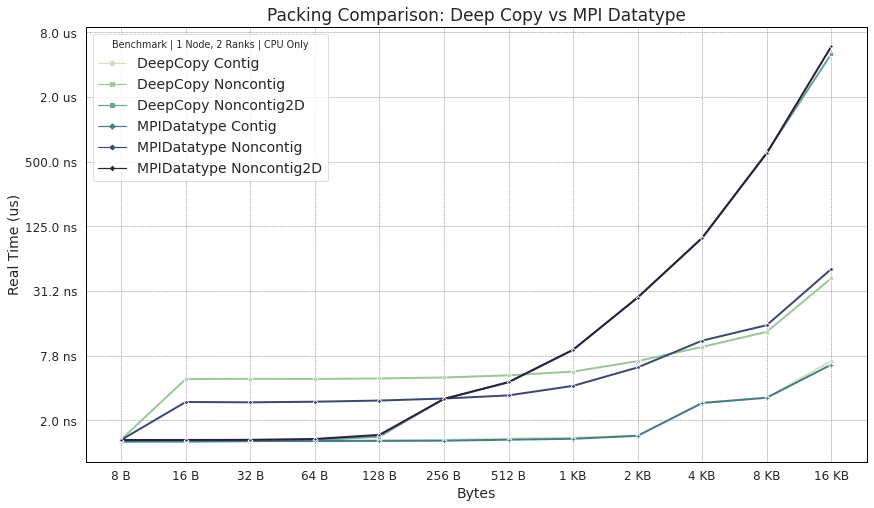

In [250]:
# mpirun -np 2 ./build/perf_tests/perf_test-main 
# --benchmark_repetitions=5 --benchmark_filter=3dslice 
# --benchmark_format=json > "output$(date '+%Y%m%d%H%M%S').json"

# Plot 0: Compare All, CPU
plt.figure(figsize=(14, 8))
plt.title('Packing Comparison: Deep Copy vs MPI Datatype', fontsize=fontsize + 4)

# Create a pastel rainbow color palette
palette = sbrn.cubehelix_palette(start=0.5, rot=-0.75, light=0.85, dark=0.15, n_colors=len(edf['combined_type'].unique()))

# Plot with custom palette and solid lines
sbrn.lineplot(data=edf, x='bytes', y='real_time', hue='combined_type', 
              style='combined_type', markers=True, ci=None, linewidth=2, palette=palette, dashes=False)

plt.legend(title='Benchmark | 1 Node, 2 Ranks | CPU Only', fontsize=fontsize+1)
plt.xlabel('Bytes', fontsize=fontsize+1)
plt.ylabel('Real Time (us)', fontsize=fontsize+1)
plt.xticks(fontsize=fontsize-1)
plt.yticks(fontsize=fontsize-1)

plt.gca().set_xscale("log", base=2)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

# Increase the number of x-axis ticks
from matplotlib.ticker import LogLocator
plt.gca().xaxis.set_major_locator(LogLocator(base=2, numticks=20))

plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.savefig("./PNG/3dslice1node.png", dpi=300)
plt.show()

In [251]:
# Define subsets to plot separately
subset1 = edf[(edf['pack_type'] == 'DeepCopy') & (edf['slice_type'] == 'Contig') | 
              (edf['pack_type'] == 'MPIDatatype') & (edf['slice_type'] == 'Contig')]

subset2 = edf[(edf['pack_type'] == 'DeepCopy') & (edf['slice_type'] == 'Noncontig') | 
              (edf['pack_type'] == 'MPIDatatype') & (edf['slice_type'] == 'Noncontig')]

subset3 = edf[(edf['pack_type'] == 'DeepCopy') & (edf['slice_type'] == 'Noncontig2D') | 
              (edf['pack_type'] == 'MPIDatatype') & (edf['slice_type'] == 'Noncontig2D')]

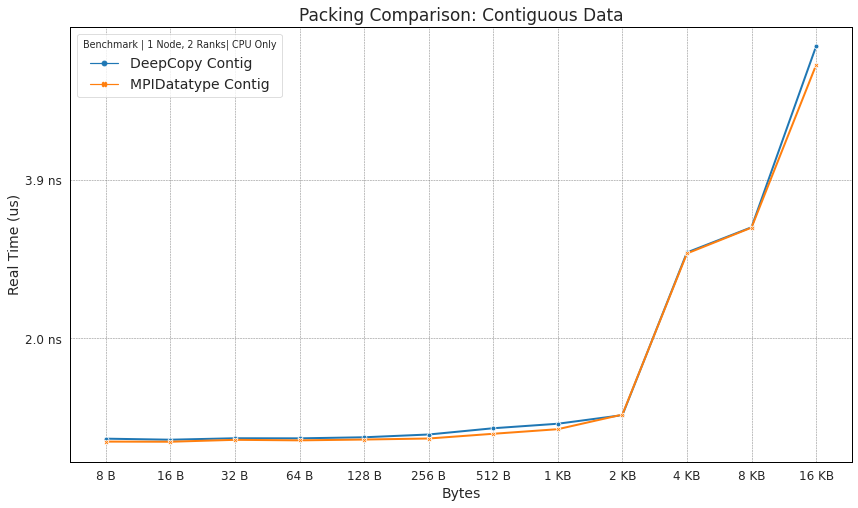

In [252]:
# Plot 1: Contig, CPU
plt.figure(figsize=(14, 8))
plt.title('Packing Comparison: Contiguous Data', fontsize=fontsize + 4)
# Create a pastel rainbow color palette with two colors
palette = sbrn.cubehelix_palette(start=0.5, rot=-0.75, light=0.85, dark=0.15, n_colors=2)

sbrn.lineplot(data=subset1, x='bytes', y='real_time', hue='combined_type', 
              style='combined_type', markers=True, ci=None, linewidth=2, dashes=False)

plt.legend(title='Benchmark | 1 Node, 2 Ranks| CPU Only', fontsize=fontsize + 1)
plt.xlabel('Bytes', fontsize=fontsize + 1)
plt.ylabel('Real Time (us)', fontsize=fontsize + 1)
plt.xticks(fontsize=fontsize - 1)
plt.yticks(fontsize=fontsize - 1)

plt.gca().set_xscale("log", base=2)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

# Increase the number of x-axis ticks
from matplotlib.ticker import LogLocator
plt.gca().xaxis.set_major_locator(LogLocator(base=2, numticks=20))

plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.savefig("./PNG/3dslice1nodecontig.png", dpi=300)
plt.show()

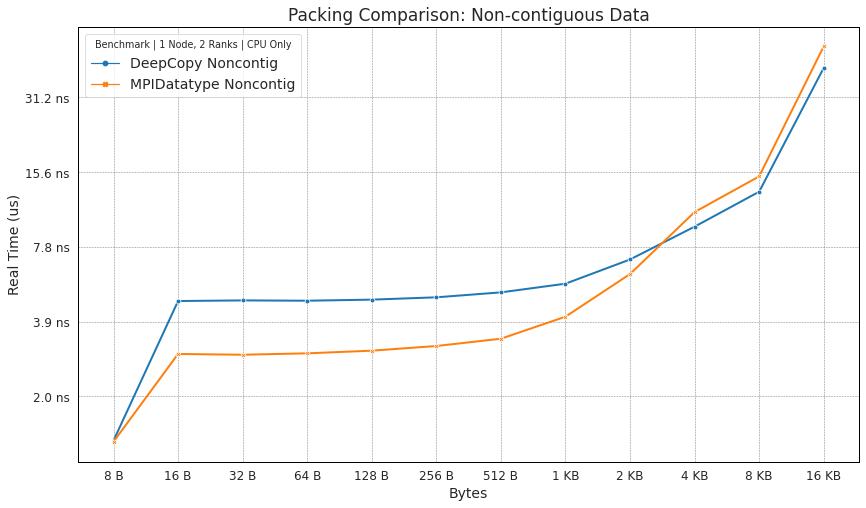

In [253]:
# Plot 2: Noncontig, CPU
plt.figure(figsize=(14, 8))
plt.title('Packing Comparison: Non-contiguous Data', fontsize=fontsize + 4)
sbrn.lineplot(data=subset2, x='bytes', y='real_time', hue='combined_type', 
              style='combined_type', markers=True, ci=None, linewidth=2, dashes=False)

plt.legend(title='Benchmark | 1 Node, 2 Ranks | CPU Only', fontsize=fontsize + 1)
plt.xlabel('Bytes', fontsize=fontsize + 1)
plt.ylabel('Real Time (us)', fontsize=fontsize + 1)
plt.xticks(fontsize=fontsize - 1)
plt.yticks(fontsize=fontsize - 1)

plt.gca().set_xscale("log", base=2)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

# Increase the number of x-axis ticks
from matplotlib.ticker import LogLocator
plt.gca().xaxis.set_major_locator(LogLocator(base=2, numticks=20))

plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.savefig("./PNG/3dslice1nodenoncontig.png", dpi=300)
plt.show()

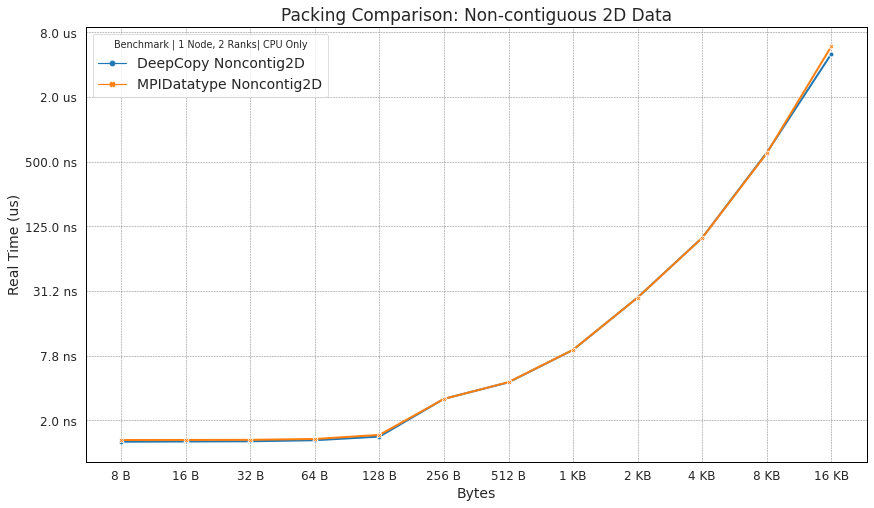

In [254]:
# Plot 3: Noncontig2D, CPU
plt.figure(figsize=(14, 8))
plt.title('Packing Comparison: Non-contiguous 2D Data', fontsize=fontsize + 4)
sbrn.lineplot(data=subset3, x='bytes', y='real_time', hue='combined_type', 
              style='combined_type', markers=True, ci=None, linewidth=2, dashes=False)

plt.legend(title='Benchmark | 1 Node, 2 Ranks| CPU Only', fontsize=fontsize + 1)
plt.xlabel('Bytes', fontsize=fontsize + 1)
plt.ylabel('Real Time (us)', fontsize=fontsize + 1)
plt.xticks(fontsize=fontsize - 1)
plt.yticks(fontsize=fontsize - 1)

plt.gca().set_xscale("log", base=2)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

# Increase the number of x-axis ticks
from matplotlib.ticker import LogLocator
plt.gca().xaxis.set_major_locator(LogLocator(base=2, numticks=20))

plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.savefig("./PNG/3dslice1nodenoncontig2d.png", dpi=300)
plt.show()

In [255]:
# Open the JSON file for reading
with open('slicejuly11_2nodes.json', 'r') as file:
    data = json.load(file)

df = pd.json_normalize(data['benchmarks'])
df['repetition_index'] = df['repetition_index'].fillna(0)

In [256]:
extracted_data = []

# Loop through the benchmarks in the JSON data
for i,benchmark in df.iterrows() :
    
    # Extract the relevant information
    name = benchmark['name']
    real_time = benchmark['real_time']
    bytes = benchmark['bytes']
    
    # Determine the packing type from the name
    if 'deepcopy' in name:
        pack_type = 'DeepCopy'
    elif 'datatype' in name:
        pack_type = 'MPIDatatype'
    else:
        continue  # Skip if none
        
    # Determine the slice type from the name
    if 'noncontig2D' in name:
        slice_type = 'Noncontig2D'
    elif 'noncontig' in name:
        slice_type = 'Noncontig'
    elif 'contig' in name:
        slice_type = 'Contig'
    
    if 'mean' in name:
        extracted_data.append({'pack_type': pack_type, 'slice_type': slice_type, 'real_time': real_time, 'bytes': bytes})
    
edf = pd.DataFrame(extracted_data)

# Create a combined column for comm_type and func_type
edf['combined_type'] = edf['pack_type'] + ' ' + edf['slice_type']

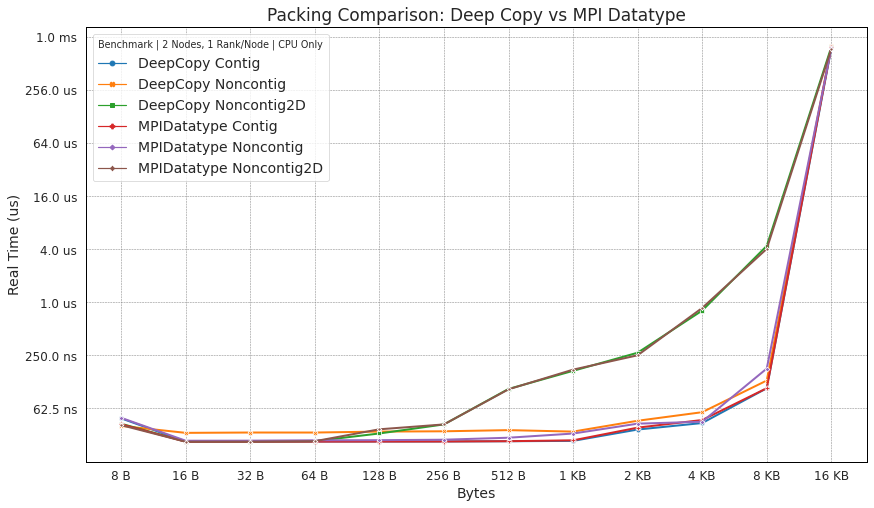

In [257]:
# mpirun -np 2 ./build/perf_tests/perf_test-main 
# --benchmark_repetitions=5 --benchmark_filter=3dslice 
# --benchmark_format=json > "output$(date '+%Y%m%d%H%M%S').json"

# Plot 4: Compare All, 2 Nodes, CPU
plt.figure(figsize=(14, 8))
plt.title('Packing Comparison: Deep Copy vs MPI Datatype', fontsize=fontsize + 4)

sbrn.lineplot(data=edf, x='bytes', y='real_time', hue='combined_type', 
              style='combined_type', markers=True, ci=None, linewidth=2, dashes=False)

plt.legend(title='Benchmark | 2 Nodes, 1 Rank/Node | CPU Only', fontsize=fontsize+1)
plt.xlabel('Bytes', fontsize=fontsize+1)
plt.ylabel('Real Time (us)', fontsize=fontsize+1)
plt.xticks(fontsize=fontsize-1)
plt.yticks(fontsize=fontsize-1)

plt.gca().set_xscale("log", base=2)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

# Increase the number of x-axis ticks
from matplotlib.ticker import LogLocator
plt.gca().xaxis.set_major_locator(LogLocator(base=2, numticks=20))

plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.savefig("./PNG/3dslice2nodes.png", dpi=300)
plt.show()

In [258]:
# Define subsets to plot separately
subset1 = edf[(edf['pack_type'] == 'DeepCopy') & (edf['slice_type'] == 'Contig') | 
              (edf['pack_type'] == 'MPIDatatype') & (edf['slice_type'] == 'Contig')]

subset2 = edf[(edf['pack_type'] == 'DeepCopy') & (edf['slice_type'] == 'Noncontig') | 
              (edf['pack_type'] == 'MPIDatatype') & (edf['slice_type'] == 'Noncontig')]

subset3 = edf[(edf['pack_type'] == 'DeepCopy') & (edf['slice_type'] == 'Noncontig2D') | 
              (edf['pack_type'] == 'MPIDatatype') & (edf['slice_type'] == 'Noncontig2D')]

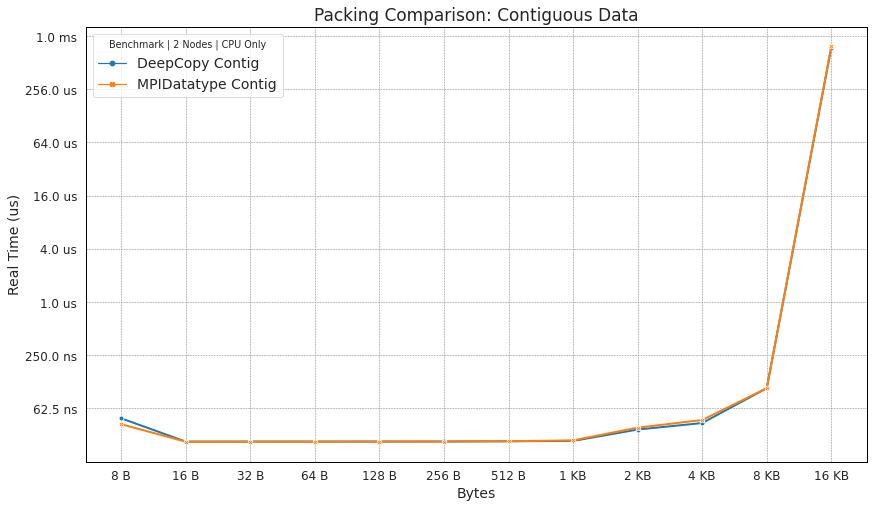

In [259]:
# Plot 5: Contig, 2 Nodes, 1 Rank per Node, CPU
plt.figure(figsize=(14, 8))
plt.title('Packing Comparison: Contiguous Data', fontsize=fontsize + 4)
sbrn.lineplot(data=subset1, x='bytes', y='real_time', hue='combined_type', 
              style='combined_type', markers=True, ci=None, linewidth=2, dashes=False)

plt.legend(title='Benchmark | 2 Nodes | CPU Only', fontsize=fontsize + 1)
plt.xlabel('Bytes', fontsize=fontsize + 1)
plt.ylabel('Real Time (us)', fontsize=fontsize + 1)
plt.xticks(fontsize=fontsize - 1)
plt.yticks(fontsize=fontsize - 1)

plt.gca().set_xscale("log", base=2)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

# Increase the number of x-axis ticks
from matplotlib.ticker import LogLocator
plt.gca().xaxis.set_major_locator(LogLocator(base=2, numticks=20))

plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.savefig("./PNG/3dslice2nodescontig.png", dpi=300)
plt.show()

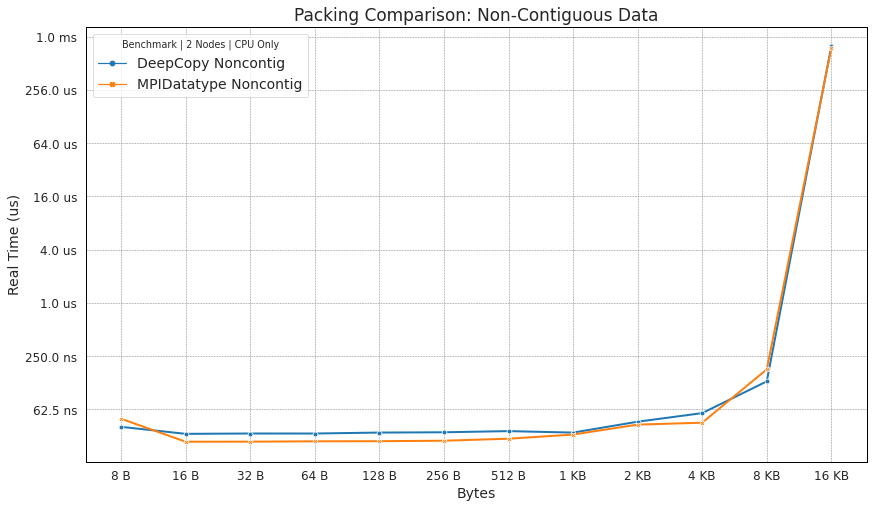

In [260]:
# Plot 6: Noncontig, 2 Nodes, 1 Rank per Node, CPU
plt.figure(figsize=(14, 8))
plt.title('Packing Comparison: Non-Contiguous Data', fontsize=fontsize + 4)
sbrn.lineplot(data=subset2, x='bytes', y='real_time', hue='combined_type', 
              style='combined_type', markers=True, ci=None, linewidth=2, dashes=False)

plt.legend(title='Benchmark | 2 Nodes | CPU Only', fontsize=fontsize + 1)
plt.xlabel('Bytes', fontsize=fontsize + 1)
plt.ylabel('Real Time (us)', fontsize=fontsize + 1)
plt.xticks(fontsize=fontsize - 1)
plt.yticks(fontsize=fontsize - 1)

plt.gca().set_xscale("log", base=2)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

# Increase the number of x-axis ticks
from matplotlib.ticker import LogLocator
plt.gca().xaxis.set_major_locator(LogLocator(base=2, numticks=20))

plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.savefig("./PNG/3dslice2nodescontig.png", dpi=300)
plt.show()

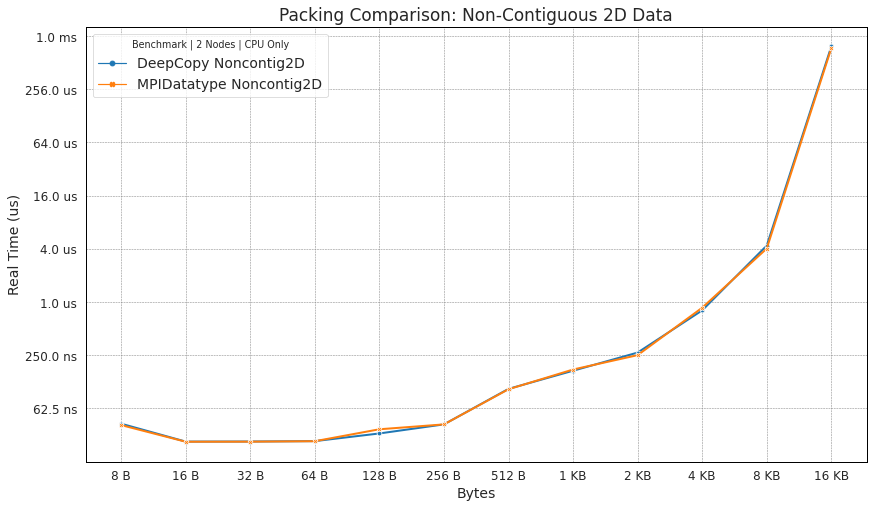

In [261]:
# Plot 6: Noncontig2D, 2 Nodes, 1 Rank per Node, CPU
plt.figure(figsize=(14, 8))
plt.title('Packing Comparison: Non-Contiguous 2D Data', fontsize=fontsize + 4)
sbrn.lineplot(data=subset3, x='bytes', y='real_time', hue='combined_type', 
              style='combined_type', markers=True, ci=None, linewidth=2, dashes=False)

plt.legend(title='Benchmark | 2 Nodes | CPU Only', fontsize=fontsize + 1)
plt.xlabel('Bytes', fontsize=fontsize + 1)
plt.ylabel('Real Time (us)', fontsize=fontsize + 1)
plt.xticks(fontsize=fontsize - 1)
plt.yticks(fontsize=fontsize - 1)

plt.gca().set_xscale("log", base=2)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

# Increase the number of x-axis ticks
from matplotlib.ticker import LogLocator
plt.gca().xaxis.set_major_locator(LogLocator(base=2, numticks=20))

plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.savefig("./PNG/3dslice2nodescontig.png", dpi=300)
plt.show()

In [262]:
# CUDA ENABLED RUNS
# Open the JSON file for reading
with open('./3DSlice_Data/1nodeCUDA.json', 'r') as file:
    data = json.load(file)

df = pd.json_normalize(data['benchmarks'])
df['repetition_index'] = df['repetition_index'].fillna(0)

In [263]:
extracted_data = []

# Loop through the benchmarks in the JSON data
for i,benchmark in df.iterrows() :
    
    # Extract the relevant information
    name = benchmark['name']
    real_time = benchmark['real_time']
    bytes = benchmark['bytes']
    
    # Determine the packing type from the name
    if 'deepcopy' in name:
        pack_type = 'DeepCopy'
    elif 'datatype' in name:
        pack_type = 'MPIDatatype'
    else:
        continue  # Skip if none
        
    # Determine the slice type from the name
    if 'noncontig2D' in name:
        slice_type = 'Noncontig2D'
    elif 'noncontig' in name:
        slice_type = 'Noncontig'
    elif 'contig' in name:
        slice_type = 'Contig'
    
    if 'mean' in name:
        extracted_data.append({'pack_type': pack_type, 'slice_type': slice_type, 'real_time': real_time, 'bytes': bytes})
    
edf = pd.DataFrame(extracted_data)

# Create a combined column for comm_type and func_type
edf['combined_type'] = edf['pack_type'] + ' ' + edf['slice_type']

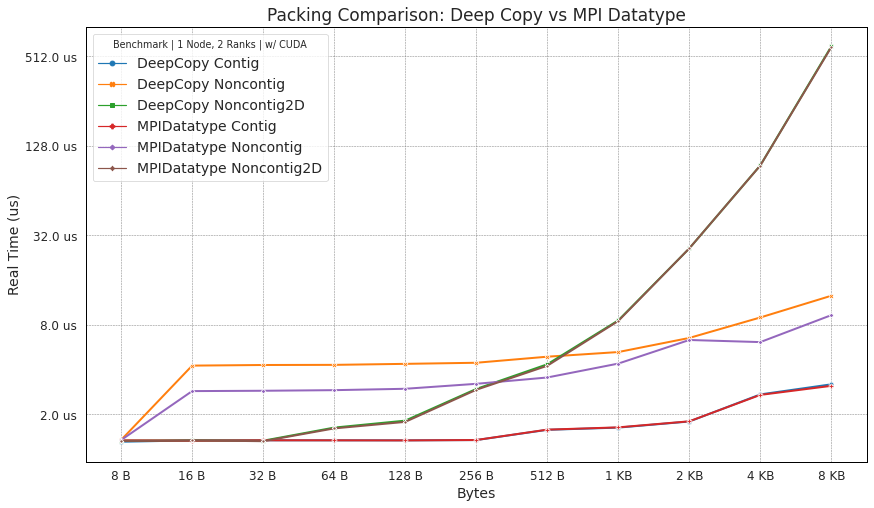

In [264]:
# CUDA_VISIBLE_DEVICES=0,1 mpirun  -np 2 ./build/perf_tests/perf_test-main 
# --benchmark_repetitions=5 --benchmark_filter=3dslice 
# --benchmark_format=json > "output$(date '+%Y%m%d%H%M%S').json"

# Plot 7: Compare All, 1 Node, GPU
plt.figure(figsize=(14, 8))
plt.title('Packing Comparison: Deep Copy vs MPI Datatype', fontsize=fontsize + 4)

sbrn.lineplot(data=edf, x='bytes', y='real_time', hue='combined_type', 
              style='combined_type', markers=True, ci=None, linewidth=2, dashes=False)

plt.legend(title='Benchmark | 1 Node, 2 Ranks | w/ CUDA', fontsize=fontsize+1)
plt.xlabel('Bytes', fontsize=fontsize+1)
plt.ylabel('Real Time (us)', fontsize=fontsize+1)
plt.xticks(fontsize=fontsize-1)
plt.yticks(fontsize=fontsize-1)

plt.gca().set_xscale("log", base=2)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

# Increase the number of x-axis ticks
from matplotlib.ticker import LogLocator
plt.gca().xaxis.set_major_locator(LogLocator(base=2, numticks=20))

plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.savefig("./PNG/3dslice1nodeCUDA.png", dpi=300)
plt.show()

In [265]:
# Define subsets to plot separately
subset1 = edf[(edf['pack_type'] == 'DeepCopy') & (edf['slice_type'] == 'Contig') | 
              (edf['pack_type'] == 'MPIDatatype') & (edf['slice_type'] == 'Contig')]

subset2 = edf[(edf['pack_type'] == 'DeepCopy') & (edf['slice_type'] == 'Noncontig') | 
              (edf['pack_type'] == 'MPIDatatype') & (edf['slice_type'] == 'Noncontig')]

subset3 = edf[(edf['pack_type'] == 'DeepCopy') & (edf['slice_type'] == 'Noncontig2D') | 
              (edf['pack_type'] == 'MPIDatatype') & (edf['slice_type'] == 'Noncontig2D')]

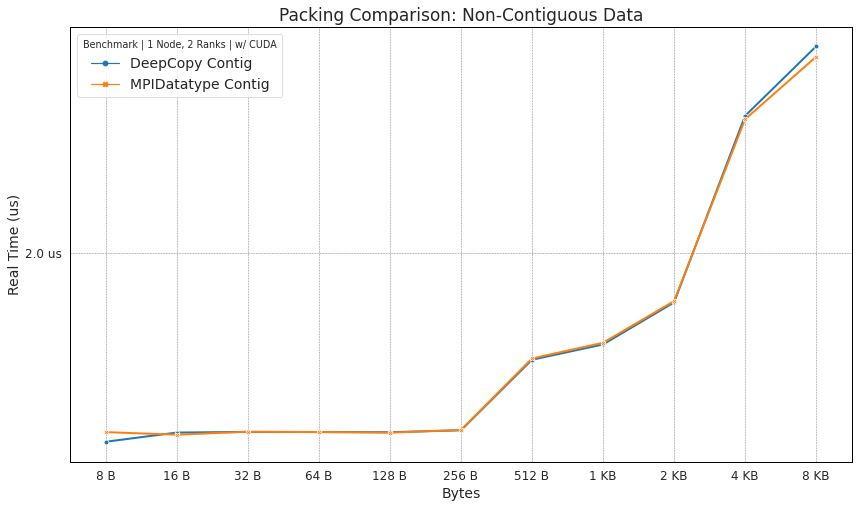

In [266]:
# Plot 8: Contig, 1 Node, GPU
plt.figure(figsize=(14, 8))
plt.title('Packing Comparison: Non-Contiguous Data', fontsize=fontsize + 4)
sbrn.lineplot(data=subset1, x='bytes', y='real_time', hue='combined_type', 
              style='combined_type', markers=True, ci=None, linewidth=2, dashes=False)

plt.legend(title='Benchmark | 1 Node, 2 Ranks | w/ CUDA', fontsize=fontsize + 1)
plt.xlabel('Bytes', fontsize=fontsize + 1)
plt.ylabel('Real Time (us)', fontsize=fontsize + 1)
plt.xticks(fontsize=fontsize - 1)
plt.yticks(fontsize=fontsize - 1)

plt.gca().set_xscale("log", base=2)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

# Increase the number of x-axis ticks
from matplotlib.ticker import LogLocator
plt.gca().xaxis.set_major_locator(LogLocator(base=2, numticks=20))

plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.savefig("./PNG/3dslice1nodecontigCUDA.png", dpi=300)
plt.show()

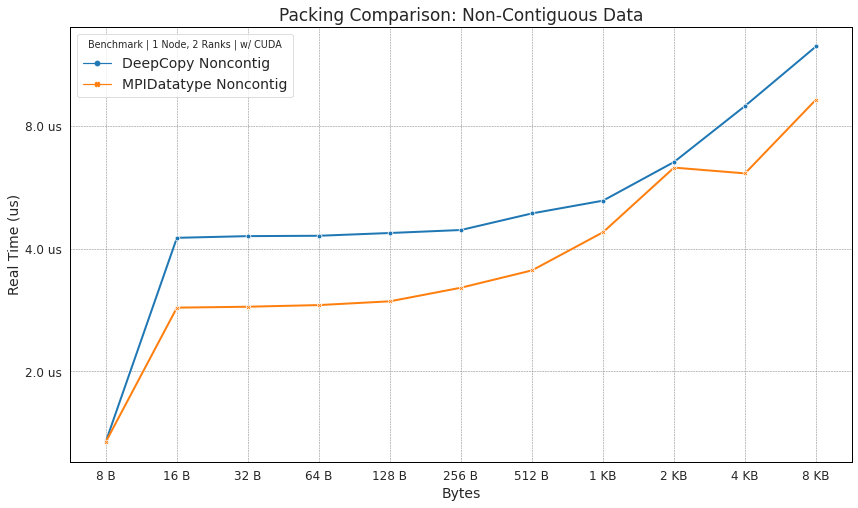

In [267]:
# Plot 9: Noncontig, 1 Node, GPU
plt.figure(figsize=(14, 8))
plt.title('Packing Comparison: Non-Contiguous Data', fontsize=fontsize + 4)
sbrn.lineplot(data=subset2, x='bytes', y='real_time', hue='combined_type', 
              style='combined_type', markers=True, ci=None, linewidth=2, dashes=False)

plt.legend(title='Benchmark | 1 Node, 2 Ranks | w/ CUDA', fontsize=fontsize + 1)
plt.xlabel('Bytes', fontsize=fontsize + 1)
plt.ylabel('Real Time (us)', fontsize=fontsize + 1)
plt.xticks(fontsize=fontsize - 1)
plt.yticks(fontsize=fontsize - 1)

plt.gca().set_xscale("log", base=2)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

# Increase the number of x-axis ticks
from matplotlib.ticker import LogLocator
plt.gca().xaxis.set_major_locator(LogLocator(base=2, numticks=20))

plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.savefig("./PNG/3dslice1nodenoncontigCUDA.png", dpi=300)
plt.show()

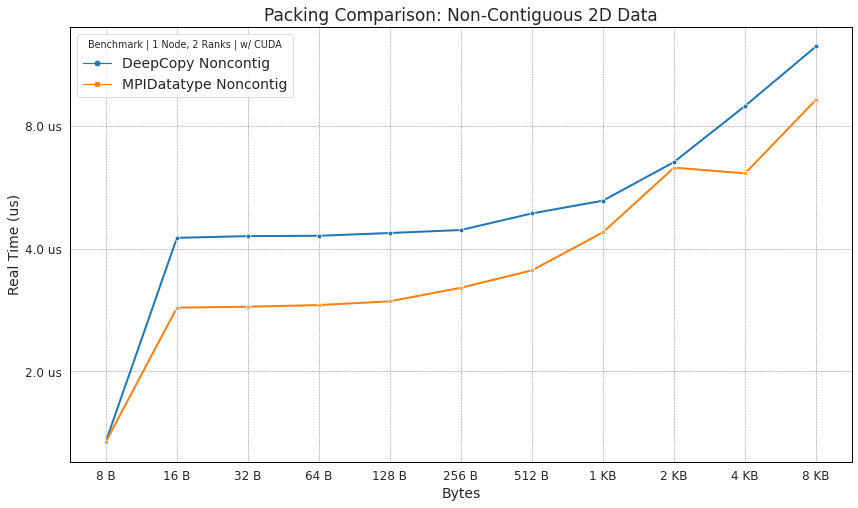

In [268]:
# Plot 10: Noncontig2D, 1 Node, GPU
plt.figure(figsize=(14, 8))
plt.title('Packing Comparison: Non-Contiguous 2D Data', fontsize=fontsize + 4)
sbrn.lineplot(data=subset2, x='bytes', y='real_time', hue='combined_type', 
              style='combined_type', markers=True, ci=None, linewidth=2, dashes=False)

plt.legend(title='Benchmark | 1 Node, 2 Ranks | w/ CUDA', fontsize=fontsize + 1)
plt.xlabel('Bytes', fontsize=fontsize + 1)
plt.ylabel('Real Time (us)', fontsize=fontsize + 1)
plt.xticks(fontsize=fontsize - 1)
plt.yticks(fontsize=fontsize - 1)

plt.gca().set_xscale("log", base=2)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

# Increase the number of x-axis ticks
from matplotlib.ticker import LogLocator
plt.gca().xaxis.set_major_locator(LogLocator(base=2, numticks=20))

plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.savefig("./PNG/3dslice1nodenoncontig2DCUDA.png", dpi=300)
plt.show()

In [269]:
# Open the JSON file for reading
with open('./3DSlice_Data/2nodesCUDA.json', 'r') as file: #TODO add file
    data = json.load(file)

df = pd.json_normalize(data['benchmarks'])
df['repetition_index'] = df['repetition_index'].fillna(0)

In [270]:
extracted_data = []

# Loop through the benchmarks in the JSON data
for i,benchmark in df.iterrows() :
    
    # Extract the relevant information
    name = benchmark['name']
    real_time = benchmark['real_time']
    bytes = benchmark['bytes']
    
    # Determine the packing type from the name
    if 'deepcopy' in name:
        pack_type = 'DeepCopy'
    elif 'datatype' in name:
        pack_type = 'MPIDatatype'
    else:
        continue  # Skip if none
        
    # Determine the slice type from the name
    if 'noncontig2D' in name:
        slice_type = 'Noncontig2D'
    elif 'noncontig' in name:
        slice_type = 'Noncontig'
    elif 'contig' in name:
        slice_type = 'Contig'
    
    if 'mean' in name:
        extracted_data.append({'pack_type': pack_type, 'slice_type': slice_type, 'real_time': real_time, 'bytes': bytes})
    
edf = pd.DataFrame(extracted_data)

# Create a combined column for comm_type and func_type
edf['combined_type'] = edf['pack_type'] + ' ' + edf['slice_type']

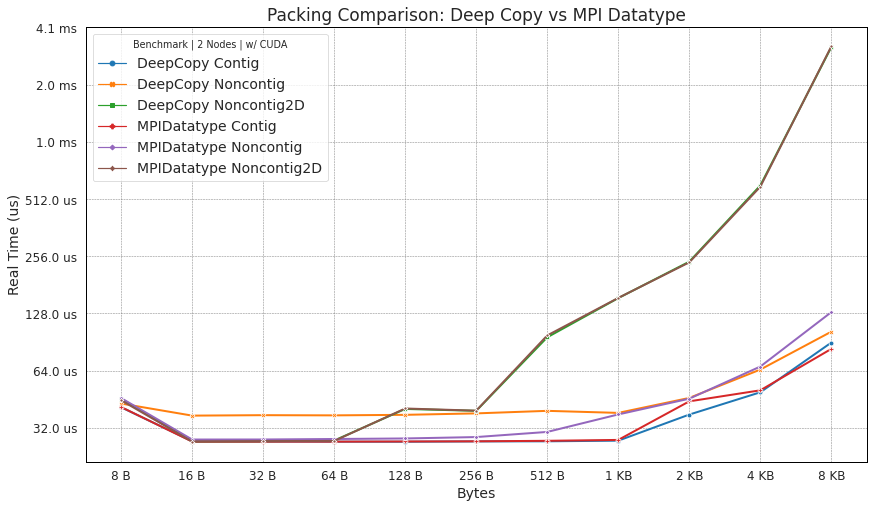

In [271]:
# Plot 11: Compare All, 2 Nodes, 1 Rank per Node, GPU
plt.figure(figsize=(14, 8))
plt.title('Packing Comparison: Deep Copy vs MPI Datatype', fontsize=fontsize + 4)

sbrn.lineplot(data=edf, x='bytes', y='real_time', hue='combined_type', 
              style='combined_type', markers=True, ci=None, linewidth=2, dashes=False)

plt.legend(title='Benchmark | 2 Nodes | w/ CUDA', fontsize=fontsize+1)
plt.xlabel('Bytes', fontsize=fontsize+1)
plt.ylabel('Real Time (us)', fontsize=fontsize+1)
plt.xticks(fontsize=fontsize-1)
plt.yticks(fontsize=fontsize-1)

plt.gca().set_xscale("log", base=2)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

# Increase the number of x-axis ticks
from matplotlib.ticker import LogLocator
plt.gca().xaxis.set_major_locator(LogLocator(base=2, numticks=20))

plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.savefig("./PNG/3dslice2nodesCUDA.png", dpi=300)
plt.show()

In [272]:
# Define subsets to plot separately
subset1 = edf[(edf['pack_type'] == 'DeepCopy') & (edf['slice_type'] == 'Contig') | 
              (edf['pack_type'] == 'MPIDatatype') & (edf['slice_type'] == 'Contig')]

subset2 = edf[(edf['pack_type'] == 'DeepCopy') & (edf['slice_type'] == 'Noncontig') | 
              (edf['pack_type'] == 'MPIDatatype') & (edf['slice_type'] == 'Noncontig')]

subset3 = edf[(edf['pack_type'] == 'DeepCopy') & (edf['slice_type'] == 'Noncontig2D') | 
              (edf['pack_type'] == 'MPIDatatype') & (edf['slice_type'] == 'Noncontig2D')]

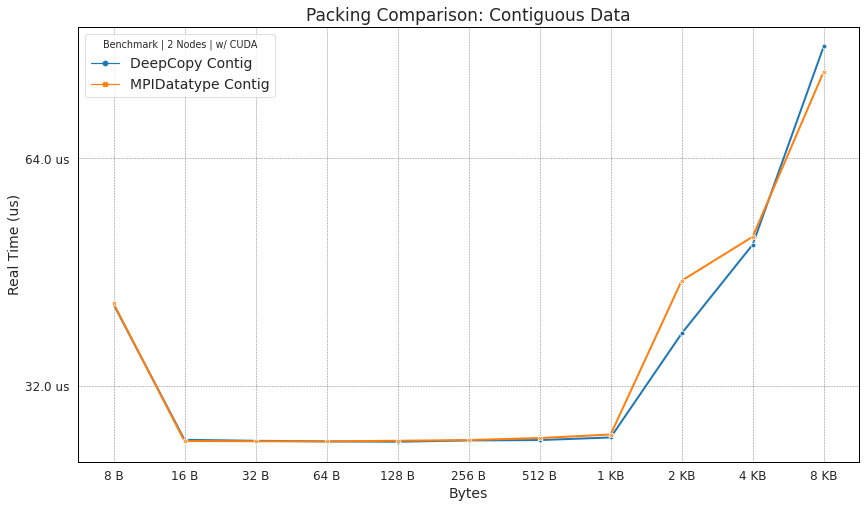

In [273]:
# Plot 12: Contiguous, 2 Nodes, 1 Rank per Node, GPU
plt.figure(figsize=(14, 8))
plt.title('Packing Comparison: Contiguous Data', fontsize=fontsize + 4)
sbrn.lineplot(data=subset1, x='bytes', y='real_time', hue='combined_type', 
              style='combined_type', markers=True, ci=None, linewidth=2, dashes=False)

plt.legend(title='Benchmark | 2 Nodes | w/ CUDA', fontsize=fontsize + 1)
plt.xlabel('Bytes', fontsize=fontsize + 1)
plt.ylabel('Real Time (us)', fontsize=fontsize + 1)
plt.xticks(fontsize=fontsize - 1)
plt.yticks(fontsize=fontsize - 1)

plt.gca().set_xscale("log", base=2)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

# Increase the number of x-axis ticks
from matplotlib.ticker import LogLocator
plt.gca().xaxis.set_major_locator(LogLocator(base=2, numticks=20))

plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.savefig("./PNG/3dslice2nodescontigCUDA.png", dpi=300)
plt.show()

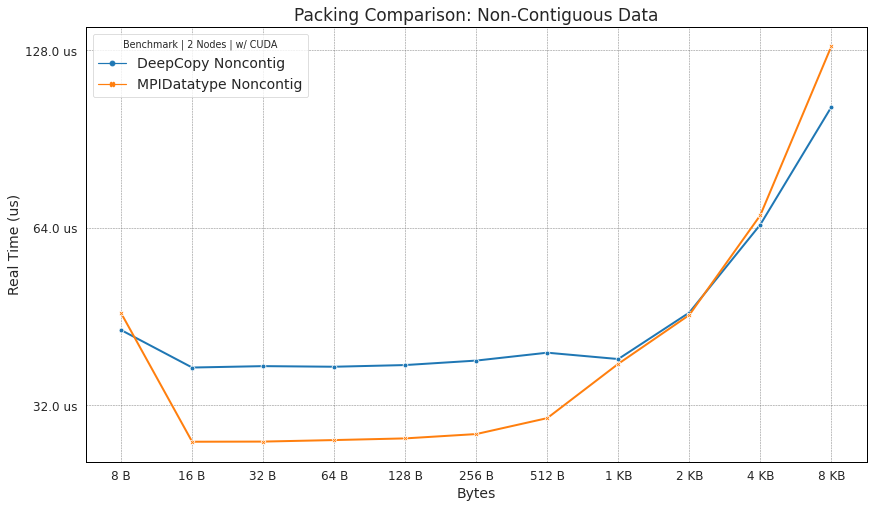

In [274]:
# Plot 13: Noncontiguous, 2 Nodes, 1 Rank per Node, GPU
plt.figure(figsize=(14, 8))
plt.title('Packing Comparison: Non-Contiguous Data', fontsize=fontsize + 4)
sbrn.lineplot(data=subset2, x='bytes', y='real_time', hue='combined_type', 
              style='combined_type', markers=True, ci=None, linewidth=2, dashes=False)

plt.legend(title='Benchmark | 2 Nodes | w/ CUDA', fontsize=fontsize + 1)
plt.xlabel('Bytes', fontsize=fontsize + 1)
plt.ylabel('Real Time (us)', fontsize=fontsize + 1)
plt.xticks(fontsize=fontsize - 1)
plt.yticks(fontsize=fontsize - 1)

plt.gca().set_xscale("log", base=2)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

# Increase the number of x-axis ticks
from matplotlib.ticker import LogLocator
plt.gca().xaxis.set_major_locator(LogLocator(base=2, numticks=20))

plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.savefig("./PNG/3dslice2nodesnoncontigCUDA.png", dpi=300)
plt.show()

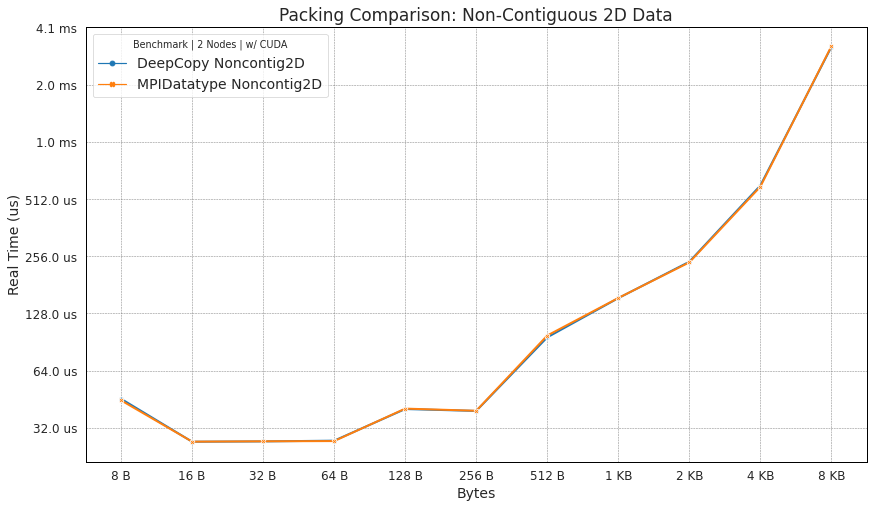

In [275]:
# Plot 14: Noncontiguous2D, 2 Nodes, 1 Rank per Node, GPU
plt.figure(figsize=(14, 8))
plt.title('Packing Comparison: Non-Contiguous 2D Data', fontsize=fontsize + 4)
sbrn.lineplot(data=subset3, x='bytes', y='real_time', hue='combined_type', 
              style='combined_type', markers=True, ci=None, linewidth=2, dashes=False)

plt.legend(title='Benchmark | 2 Nodes | w/ CUDA', fontsize=fontsize + 1)
plt.xlabel('Bytes', fontsize=fontsize + 1)
plt.ylabel('Real Time (us)', fontsize=fontsize + 1)
plt.xticks(fontsize=fontsize - 1)
plt.yticks(fontsize=fontsize - 1)

plt.gca().set_xscale("log", base=2)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

# Increase the number of x-axis ticks
from matplotlib.ticker import LogLocator
plt.gca().xaxis.set_major_locator(LogLocator(base=2, numticks=20))

plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.savefig("./PNG/3dslice2nodesnoncontig2dCUDA.png", dpi=300)
plt.show()